<a href="https://colab.research.google.com/github/mreskandarinasab/COVID-19-Tweets-Sentiment-Analysis-using-BERT-Transformer/blob/main/covid_19_tweet_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SENTIMENT ANALYSIS + EDA ON COVID 19 TWEETS
*The pandemic has really affected us in every domain, with tweets flowing like a river let us see what sentiments does it hold*

***IN this notebook we'll study the tweets on covid-19* and also perform Sentiment analysis so sit back to enjoy the power of BERT transformer**

On October 2018 Bert paper was invented and since then there's no looking back...

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
!pip install opendatasets
!pip install transformers==3

In [ ]:
# Download the data from kaggle
import opendatasets as od
od.download("https://www.kaggle.com/datasets/gpreda/covid19-tweets")
od.download("https://www.kaggle.com/datasets/surajkum1198/twitterdata")
od.download("https://www.kaggle.com/datasets/abhishek/bert-base-uncased")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/twitterdata/finalSentimentdata2.csv")

In [ ]:
data.head()

In [ ]:
data.shape

Count plot of sentiments,we can see that sad and fear are prevailing which is quite obvious

In [ ]:
sns.countplot(data['sentiment'])

***Data Preprocessing***

In [ ]:
import nltk
import re
import string

A function to clean data it removes all the punctuation marks, urls etc

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

Function to remove emoji

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
data['text']=data['text'].apply(lambda x: remove_emoji(x))

Checking the maximum length of tweet 

In [ ]:
data['text'].apply(lambda x:len(str(x).split())).max()

61

**Word cloud of 50 most  common words in India**

In [ ]:
from wordcloud import WordCloud, STOPWORDS

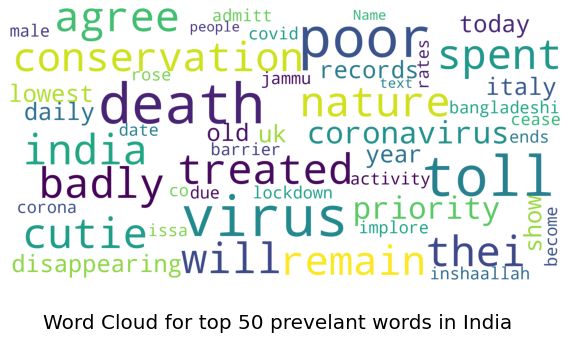

In [ ]:
 word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(data['text']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 50 prevelant words in India', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

Let's  label encode the sentiments

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb= LabelEncoder()

In [ ]:
lb.fit(data['sentiment'])

LabelEncoder()

In [ ]:
classes= list(lb.classes_)

In [ ]:
classes

['anger', 'fear', 'joy', 'sad']

In [ ]:
data['sentiment']= lb.fit_transform(data['sentiment'])

So basically the encoding is anger-0.fear-1,joy-2,sad-3

In [ ]:
data.head()

,Unnamed: 0,sentiment,text
0,3204,3,agree the poor in india are treated badly thei...
1,1431,2,if only i could have spent the with this cutie...
2,654,2,will nature conservation remain a priority in ...
3,2530,3,coronavirus disappearing in italy show this to...
4,2296,3,uk records lowest daily virus death toll since...


# Sentiment analysis
Now let's get our hands dirty with BERT transformer

# What is BERT?

*BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.*
this is how researchers defined Bert

Let's break it down simply:
First, it’s easy to get that BERT stands for Bidirectional Encoder Representations from Transformers. Each word here has a meaning to it and we will encounter that one by one in this article. For now, the key takeaway from this line is – BERT is based on the Transformer architecture.


The BERT architecture builds on top of Transformer. We currently have two variants available:

BERT Base: 12 layers (transformer blocks), 12 attention heads, and 110 million parameters
BERT Large: 24 layers (transformer blocks), 16 attention heads and, 340 million parameters


Let's implement Pytorch:-

In [ ]:
import torch
import torch.nn as nn

In [ ]:
#importing transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

I'll implement my codes, with the help of  hugging face documentation

https://huggingface.co/transformers/model_doc/bert.html

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
#setting device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

You can install the bert base uncased, from kaggle

In [ ]:
PRE_TRAINED_MODEL_NAME = '/content/bert-base-uncased'

Initialising Bert tokenizer
BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Let's implement it on sample text what it basically does is convert sentence to words(tokens) and assign each word a numerical value(token ids)

In [ ]:
sample_txt = 'These are tough times we must stand together'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: These are tough times we must stand together
   Tokens: ['these', 'are', 'tough', 'times', 'we', 'must', 'stand', 'together']
Token IDs: [2122, 2024, 7823, 2335, 2057, 2442, 3233, 2362]


Encode plus does all the work of adding special tokens, CLS as starting and SEP as ending , it also pad the sentence to maximum length provided, it also provide attention mask

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

# Choosing Sequence Length
BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:

In [ ]:
token_lens = []
for txt in data.text:
    
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

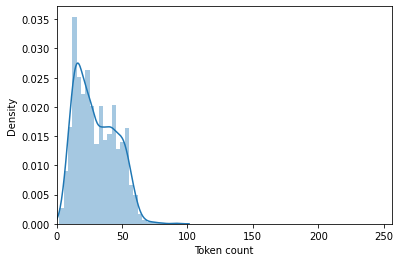

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the tweets contain less than 100 tokens but we'll be on the safe side and consider maximum length 100

In [ ]:
MAX_LEN=100

# Let us create our dataset...

In [ ]:
class Covid19Tweet(Dataset):
    
    def __init__(self, tweets, sentiment, tokenizer, max_len):
        
        
        self.tweets = tweets
        self.sentiment = sentiment
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        
        tweets = str(self.tweets[item])
        sentiment = self.sentiment[item]
        encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'tweet_text': tweets,
         'input_ids': encoding['input_ids'].flatten(),
         'attention_mask': encoding['attention_mask'].flatten(),
         'sentiments': torch.tensor(sentiment, dtype=torch.long)
          }

**Code Implementation**
first of all we'll implement a class named Covid19Tweet which takes dataset, as input, components of class are:-
1. Init function, in init function we'll define the components of our dataset, namely tweet text,sentiment and attention mask and input token id
2. len function returns the length of dataset
3. get item,  returns the actual items also it performs encoding

In [ ]:
data.head()

,Unnamed: 0,sentiment,text
0,3204,3,agree the poor in india are treated badly thei...
1,1431,2,if only i could have spent the with this cutie...
2,654,2,will nature conservation remain a priority in ...
3,2530,3,coronavirus disappearing in italy show this to...
4,2296,3,uk records lowest daily virus death toll since...


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, val = train_test_split(
  data,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [ ]:
train.shape,val.shape

((2781, 3), (309, 3))

Dataloader:-
converts data to be fed into classifier

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Covid19Tweet(tweets=data.text.to_numpy(),
    sentiment=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)
BATCH_SIZE = 32
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
df = next(iter(train_data_loader))
df.keys()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'sentiments'])

In [ ]:
print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['sentiments'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


# BERT MODEL
First we'll define model from pre trained Bert model,
Next we'll  define a class named Sentiment classifier


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        output = self.drop(pooled_output)
        return self.out(output)

# **Code Implementation**
Our class is the subclass, of nn.Module class which is the base class for all the for all neural network modules.
In the clas we have following components:-
1. Init function,it has a constructor function which initialises the components of classifier, and forward function which perform forward propagation,

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we’re returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

In [ ]:
n_classes= 4

Let’s create an instance and move it to the GPU

In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [ ]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

In [ ]:
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

To get the predicted probabilities from our trained model, we’ll apply the softmax function to the outputs

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask),dim=1)

In [ ]:
model.parameters

To reproduce training features from the BERT paper, we will use AdamW optimizer,Implements Adam algorithm with weight decay

 also use get_linear_schedule_with_warmup create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
 
 we'll use loss function as Cross Entropy

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Training with each epoch, it returns loss and accuracy with each step, and use gradient clipping to prrevent gradiemt clipping and optimize each step

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples):  
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["sentiments"].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

We'll do the same with evaluation, except for optimization

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["sentiments"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        return correct_predictions.double() / n_examples, np.mean(losses)
            
                

In [ ]:
from collections import defaultdict

Printing results......

In [64]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(val))
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc.cpu().numpy())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.cpu().numpy())
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.002682715461016686 accuracy 0.9996404171161453
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 2/10
----------
Train loss 0.003120687345294389 accuracy 0.9989212513484358
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 3/10
----------
Train loss 0.004938822273759107 accuracy 0.9989212513484358
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 4/10
----------
Train loss 0.0017976085688843895 accuracy 0.9996404171161453
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 5/10
----------
Train loss 0.0032129691707655445 accuracy 0.9992808342322905
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 6/10
----------
Train loss 0.0025756798093153656 accuracy 0.9996404171161453
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 7/10
----------
Train loss 0.0016270423637189228 accuracy 1.0
Val   loss 1.1886324882507324 accuracy 0.7896440129449839

Epoch 8/10
----------
Train loss 0.00152408383

Plotting results

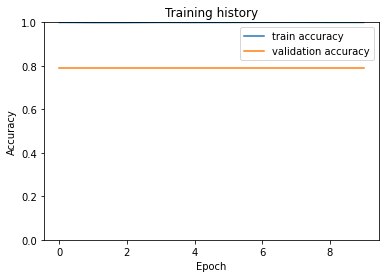

In [65]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Predicting on a raw text:-

In [66]:
review_text = 'Life has come to standstill due to this pandemic, milllions have lost their job '

In [67]:
encoded_review = tokenizer.encode_plus(review_text,max_length=MAX_LEN,add_special_tokens=True,
                                           return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,
                                           return_tensors='pt')

In [68]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print('Review text :{}'.format(review_text))
print('Sentiment :{}'.format(classes[prediction]))

Review text :Life has come to standstill due to this pandemic, milllions have lost their job 
Sentiment :sad


# The end.